![CC-BY-SA](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-sa.svg)


This notebook was created by [Bernardo Freitas Paulo da Costa](http://www.im.ufrj.br/bernardofpc),
and is licensed under Creative Commons BY-SA.

Antes de enviar este Teste, verifique que tudo está funcionando como esperado.
Por exemplo, **rode o código inteiro, do zero**.
Para isso, vá no menu, escolha _Kernel_, depois _Restart & Run All_.

Verifique, também, que você respondeu todas as questões:
* as questões de código têm `YOUR CODE HERE` (e você pode apagar o `raise NotImplemented` ao incluir sua resposta)
* as questões discursivas têm "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Regressão periódica

## Dados

Nesta primeira parte iremos ajustar uma curva aos dados de demanda elétrica fornecidos pelo ONS,
para o período entre os dias *16.04.2018 - 16.05.2018*.

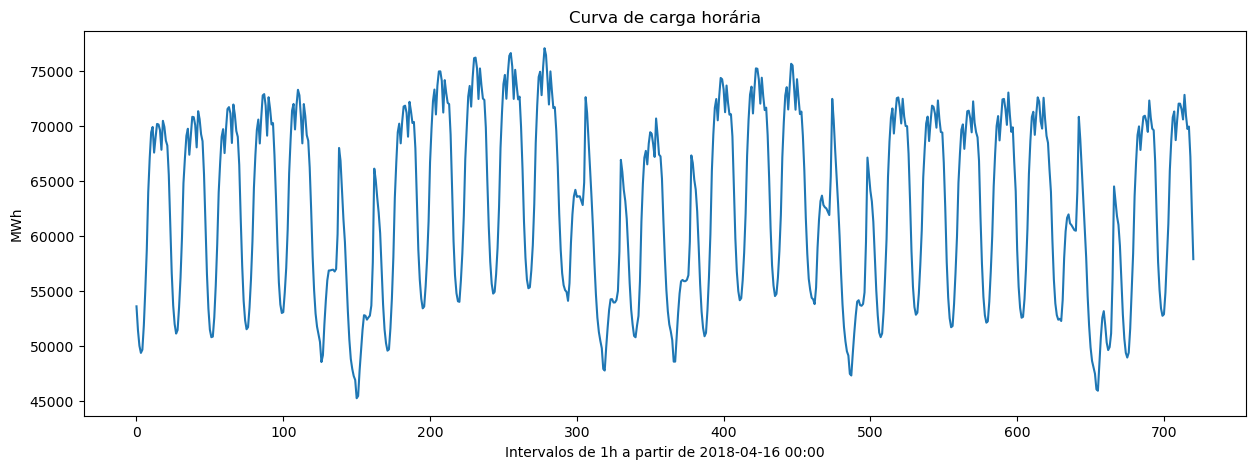

In [2]:
cch = np.load('Demanda_16.04.2018-16.05.2018.npz')
ys = cch['Demanda']
ts = np.arange(len(ys))

plt.figure(figsize=(15,5))
plt.plot(ts,ys)
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

Vamos pegar um intervalo com dias úteis.

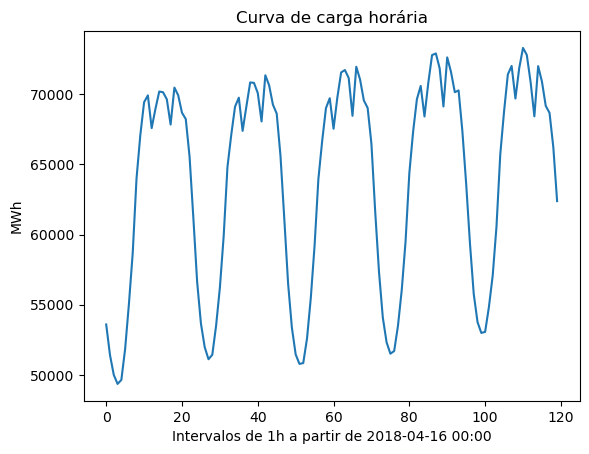

In [3]:
tmax = 120

plt.plot(ts[:tmax],ys[:tmax])
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

# Parte 1: Ajuste simples

## Questão 1: Matriz da regressão

O que salta aos olhos é o comportamento aproximadamente periódico,
logo uma primeira idéia é ajustar um modelo com funções também periódicas.

Um ajuste simples é o seguinte:
$$y(t) = c_0 + c_1\sin\left(\frac{2\pi t}{24}\right) + c_2\cos\left(\frac{2\pi t}{24}\right)$$

Explique porque o denominador 24 faz sentido para estes dados que temos.

Por que como cada dia possui 24 horas, os dados ficam mais compactos e assim podemos definir t como dias e não horas.

Escreva a função `make_trig_matrix(ts,p)`, que monta a matriz de regressão $X$ tal que $Xc = y$ para o modelo proposto acima para `ts` e com período `p`.

**Observações:**
- A função constante está na base;
- A ordem das colunas importa para os asserts (mas não para o ajuste, se você sabe o que faz).
  Assim, as colunas devem vir na ordem das funções: constante, seno, cosseno.

In [4]:
def make_trig_matrix(ts,p):
    """ Retorna a matriz de regressão para o modelo y(t) = c0 + c1*sin(2*pi*t/p) + c2*cos(2*pi*t/p). """
    ts = np.array(ts)
    return np.array([[1] * len(ts), np.sin(2*np.pi*ts/p), np.cos(2*np.pi*ts/p)]).transpose()

In [5]:
tss = np.linspace(-2*np.pi,2*np.pi,51)
X = make_trig_matrix(tss,np.pi)

assert all([np.isclose(X[i][0],1) for i in range(10)])

In [6]:
# Testes de periodicidade

assert np.allclose(X[0][1],X[-1][1])
assert np.allclose(X[0][1],X[len(tss)//2][1])
assert np.allclose(X[0][2],X[-1][2])
assert np.allclose(X[0][2],X[len(tss)//2][2])

## Questão 2: Gráficos

Faça o gráfico tanto dos dados como do ajuste do modelo,
usando apenas as 120 primeiras observações, que correspondem aos primeiros cinco dias úteis.

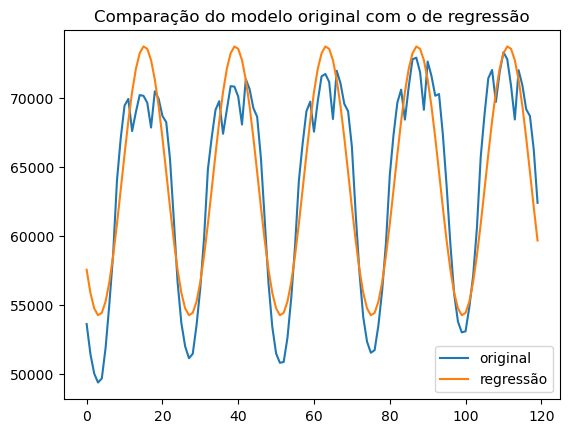

In [7]:
tmax = 120

matriz = make_trig_matrix(ts[:tmax],24)
coef, *_ = np.linalg.lstsq(matriz, ys[:tmax], rcond=None)
regress=[]
for x in ts[:tmax]:
    regress.append(coef[0] + coef[1]*np.sin(2*np.pi*x/24) + coef[2]*np.cos(2*np.pi*x/24))

plt.plot(ts[:tmax],ys[:tmax],label="original")
plt.plot(ts[:tmax], regress, label="regressão")
plt.title("Comparação do modelo original com o de regressão")
plt.legend()
ax = plt.gca()
plt.show()

In [8]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

yss = [ax.lines[i].get_ydata() for i in range(2)]

assert 73000 <= np.max(yss) <= 73800
assert 49000 <= np.min(yss) <= 50000

In [9]:
ax = None

Plote também o residual (erro de ajuste)!

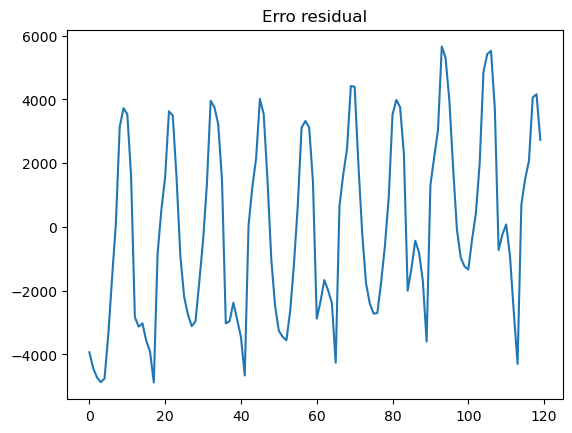

In [10]:
plt.plot(ts[:tmax],ys[:tmax]-regress)
plt.title("Erro residual")
ax = plt.gca()
plt.show()

In [11]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1


In [12]:
ax = None

Esse gráfico reflete alguma tendência nos dados que difere do ajuste?
Se sim qual função poderia ser acrescentada a base do modelo para tentar capturar essa tendência?

Aos poucos ele vai tendo um crescimento linear, se adicionarmos uma reta($y=ax+b$) ao grafico veremos que ela possui uma inclinação positiva

O que mais você percebe no gráfico de erros?

Como é uma regressão por funções trigonométricas o erro tbm é periodico

## Questão 3: Uma base maior

Agora, vamos tentar um ajuste com mais funções periódicas (também ditas _harmônicas_):
$$y(t) = \alpha_0 +  \sum_{i=1}^k\alpha_i \sin\left(\frac{2\pi it}{24}\right) + \sum_{i=1}^k\beta_i \cos\left(\frac{2\pi it}{24}\right).$$

Para te auxiliar nessa tarefa escreva a função
- `make_full_trig_matrix(ts,p,k)`: Semelhante a `make_trig_matrix`, mas retorna a matriz para o ajuste acima,
  correspondente ao conjunto de harmônicos de $i=1$ até $i = k$.

In [13]:
def make_full_trig_matrix(ts,p,k):
    ts = np.array(ts)
    ans = [[1] * len(ts)]
    for x in range(k):
        ans += [np.sin(2*np.pi*(x+1)*ts/p)]
        ans += [np.cos(2*np.pi*(x+1)*ts/p)]
    return np.array(ans).transpose()

In [14]:
# Teste de sanidade
tss = np.arange(0,100)

X = make_full_trig_matrix(tss, 24, 1)
Y = make_trig_matrix(tss, 24)

for i in range(5):
    for j in range(3):
        assert np.isclose(X[i][j],Y[i][j])

In [15]:
# Teste de dimensão
tss = np.arange(0,100)

X = make_full_trig_matrix(tss, 24, 3)
assert np.shape(X) == (100,7)

## Questão 4: Gráficos de novo

Faça o gráfico do ajuste para $k = 2$, novamente para os 5 primeiros dias úteis.

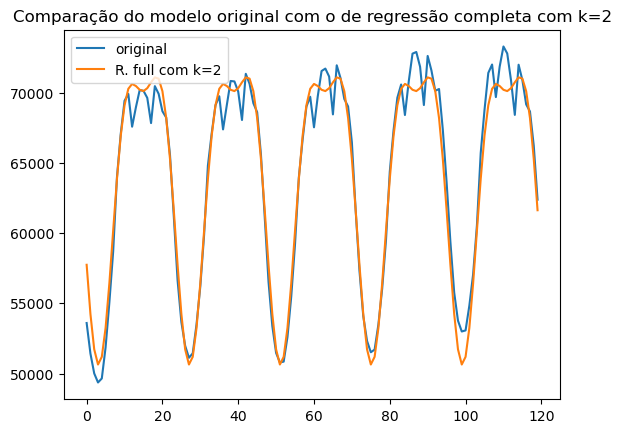

In [16]:
matriz = make_full_trig_matrix(ts[:tmax], 24, 2)
coef, *_ = np.linalg.lstsq(matriz, ys[:tmax], rcond=None)
regress=[]
for x in ts[:tmax]: 
    ans = coef[0]
    for i in range(2):
        ans = ans + coef[2*i+1]*np.sin(2*np.pi*(i+1)*x/24)
        ans = ans + coef[2*i+2]*np.cos(2*np.pi*x*(i+1)/24)
    regress.append(ans)
plt.plot(ts[:tmax], ys[:tmax], label="original")
plt.plot(ts[:tmax], regress, label="R. full com k=2")
plt.title("Comparação do modelo original com o de regressão completa com k=2")
plt.legend()
ax = plt.gca()
plt.show()

In [17]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

for i in range(2):
    yss = ax.lines[i].get_ydata()
    assert 71000 <= np.max(yss) <= 73300
    assert 49000 <= np.min(yss) <= 51300

In [18]:
ax = None

E não se esqueça do residual.

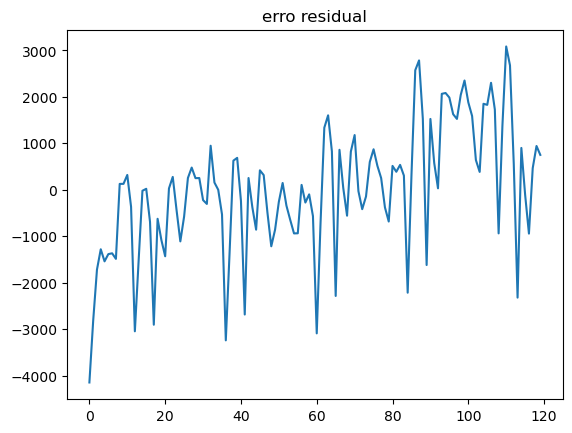

In [19]:
plt.plot(ts[:tmax],ys[:tmax]-regress)
plt.title("erro residual")
ax = plt.gca()
plt.show()

In [20]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1


In [21]:
ax = None

Agora, faça o gráfico do erro para $k = 5$, $6$ e $10$, lado a lado.

**Dica:** Faça uma função `graph_err(k, tmax)` que faz o gráfico do erro do ajuste em função de `k` e `tmax`,
e use `subplot(1,3,j)` para selecionar o $j$-ésimo eixo.
(como é inspirada do MATLAB, essa função conta a partir de 1, não zero como padrão em python).

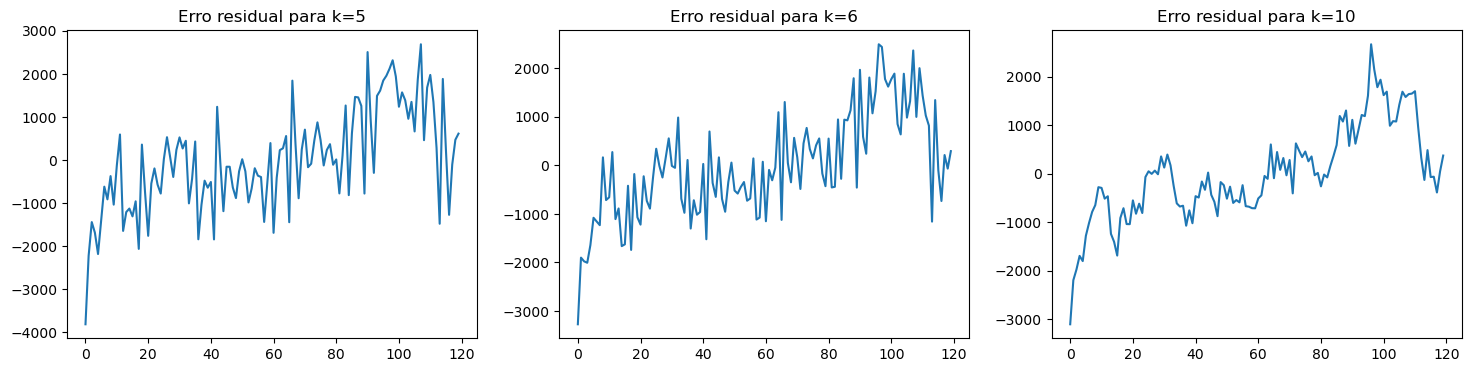

In [22]:
fig, axs = plt.subplots(ncols=3, figsize=(18,4))
def graph_err(k, tmax, j):
    def poli(k):
        matriz = make_full_trig_matrix(ts[:tmax], 24, k)
        coef, *_ = np.linalg.lstsq(matriz, ys[:tmax], rcond=None)
        regress=[]
        for x in ts[:tmax]: 
            ans = coef[0]
            for i in range(k):
                ans = ans + coef[2*i+1]*np.sin(2*np.pi*(i+1)*x/24)
                ans = ans + coef[2*i+2]*np.cos(2*np.pi*x*(i+1)/24)
            regress.append(ans)
        return regress
    regress_full = poli(k)
    erro = ys[:tmax] - regress_full
    plt.subplot(1,3,j)
    plt.plot(ts[:tmax], erro)
    plt.title("Erro residual para k={}".format(k))

ks = [5, 6, 10]
for i in range(len(ks)):
    graph_err(ks[i], tmax, i+1)
plt.show()

O que você muda e o que não muda ao aumentar $k$?

YOUR ANSWER HERE

# Parte 2: Ajuste misto

## Questão 5: Polinômios e funções trigonométricas

Vamos adicionar polinômios à base, e comparar o erro de regressão obtido com uma base um pouco maior.

Comece implementando a função `make_poly_matrix(ts, d_max)`,
que retorna a matriz de ajuste polinomial de grau até $d_\max$.

Para não duplicar a coluna de 1's na matriz do modelo completo,
a função `make_poly_matrix` não retorna a coluna correspondente às funções constantes,
mas apenas aos polinômios $X$, $X^2$, ..., $X^{d_\max}$.

In [23]:
def make_poly_matrix(ts, dmax):
    assert dmax >= 1
    return np.array([np.power(ts, i+1) for i in range(dmax)]).transpose()

In [24]:
tss = np.arange(1,5)

X = make_poly_matrix(tss,3)

assert np.allclose(X[0],[1,1,1])
assert np.allclose(X[1],[2,4,8])
assert np.allclose(X[2],[3,9,27])
assert np.allclose(X[3],[4,16,64])

Agora, faça uma função que retorna a matriz do ajuste misto

In [25]:
def make_trig_poly(ts, p, k, dmax):
    if dmax == 0:
        return make_full_trig_matrix(ts, p, k)
    else:
        return np.concatenate((make_full_trig_matrix(ts, p, k),make_poly_matrix(ts, dmax)),axis=1)

## Questão 6: Mais gráficos ainda

Trace, num mesmo eixo, os erros correspondentes aos seguintes ajustes:
- Trigonométrico original, com apenas 1 harmônico
- Trigonométrico com 6 harmônicos
- Misto com 1 harmônico e um polinômio de grau 1
- Misto com 6 harmônicos e polinômio de grau 1
- Misto com 1 harmônico e polinômios de grau até 5
- Misto com 6 harmônicos e polinômios de grau até 5

In [44]:
def graph_err(ts, ys, p, k, dmax):
    """Função auxiliar para gráfico de erros"""
    def poli(ts, ys, p, k, dmax):
        matriz = make_trig_poly(ts, p, k, dmax)
        coef, *_ = np.linalg.lstsq(matriz, ys, rcond=None)
        regress=[]
        for x in ts: 
            ans = coef[0]
            for i in range(k):
                ans = ans + coef[2*i+1]*np.sin(2*np.pi*(i+1)*x/p)
                ans = ans + coef[2*i+2]*np.cos(2*np.pi*x*(i+1)/p)
            for i in range(dmax):
                ans = ans + coef[2*k + i + 1]*np.power(x, i + 1)
            regress.append(ans)
        return regress
    regress_full = poli(ts, ys, p, k, dmax)
    erro = ys - regress_full
    plt.plot(ts, erro, label="Resíduo para k={}, dmax={}".format(k, dmax))
    plt.title("Erros Residuais para várias aproximações")
    plt.legend()

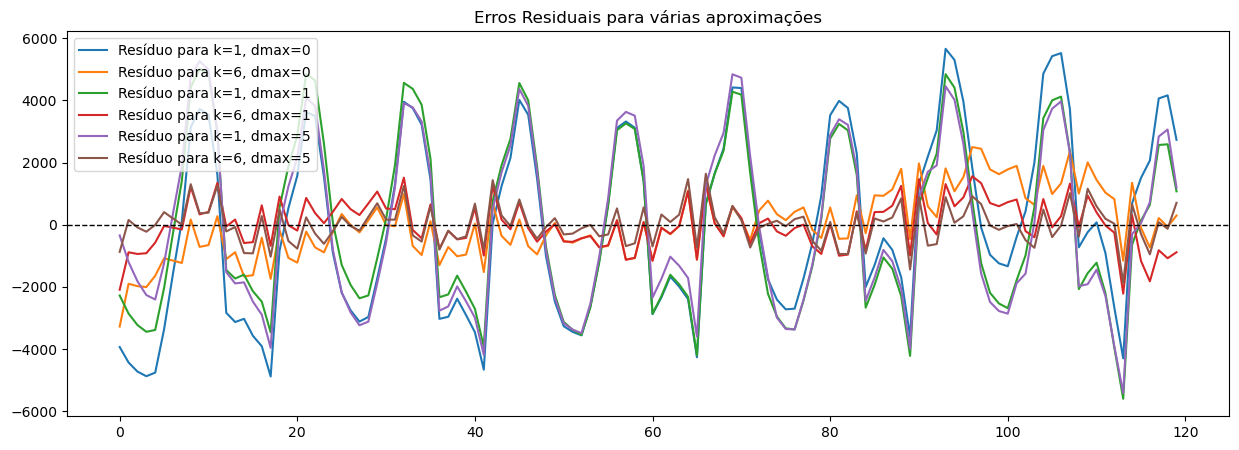

In [45]:
plt.figure(figsize=(15,5))

subts = ts[:120]
subys = ys[:120]

graph_err(subts, subys, 24, 1, 0)
graph_err(subts, subys, 24, 6, 0)
graph_err(subts, subys, 24, 1, 1)
graph_err(subts, subys, 24, 6, 1)
graph_err(subts, subys, 24, 1, 5)
graph_err(subts, subys, 24, 6, 5)

plt.axhline(color='black', linestyle='--', linewidth=1)
ax = plt.gca()
plt.show()

In [47]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 7
assert len(ax.legend().texts) == 6

O que você observou? Que melhora é obtida com o acréscimo dos polinômios da base?

A margem de erro tende a um valor bem menor com o acréscimo dos polinomios da base

Faça agora dois gráficos de erro, para separar em dois grupos.

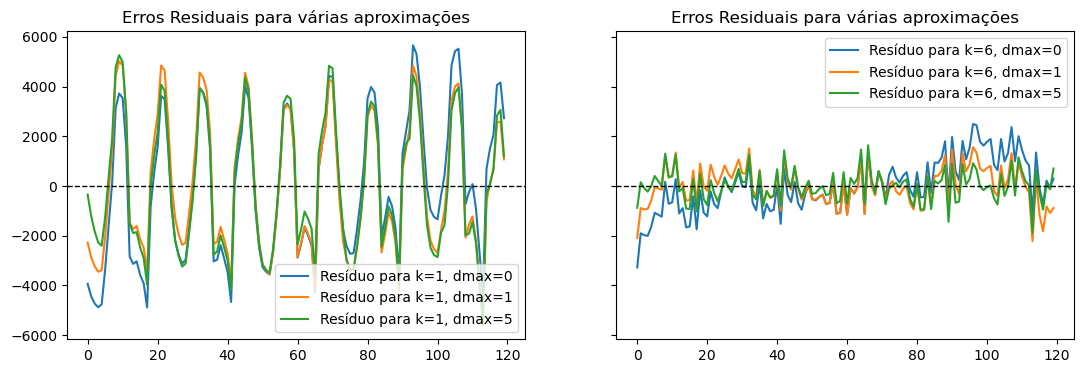

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(13,4), sharey=True)
subts = ts[:120]
subys = ys[:120]
plt.subplot(1,2,1)
graph_err(subts, subys, 24, 1, 0)
graph_err(subts, subys, 24, 1, 1)
graph_err(subts, subys, 24, 1, 5)
plt.axhline(color='black', linestyle='--', linewidth=1)

plt.subplot(1,2,2)
graph_err(subts, subys, 24, 6, 0)
graph_err(subts, subys, 24, 6, 1)
graph_err(subts, subys, 24, 6, 5)
plt.axhline(color='black', linestyle='--', linewidth=1)


- Quais são os grupos que você escolheu?
- Porquê?

YOUR ANSWER HERE